# Binning

This notebook shows the code to implement binning.
The details of how this works are provided by Professor Maffezzoli's slides.
Here, we take a look at the main problem the technique addresses and we see how the procedure works, graphically.

In [1]:
import pickle  # saving Python objects in binary form
import numpy as np
from scipy import sparse as sp
from scipy.sparse import linalg as spla
from matplotlib import pyplot as plt

In short, what is binning?
Let's take the Aiyagari model as a framework.
Every agent is subject to labor endowment shocks and they can accumulate capital.
Suppose we solve an individual's problem and we obtain a policy function $k'(k, l)$.
In solving this, we have used a grid $\mathcal{K} \in \{k_0, k_1, \ldots, k_{n-1} \}$.
Let $k^* \equiv k'(k_i, l_j)$ denote the optimal action for some value of $k_i$ and $l_j$ on the discretized state space.
Assume that $k^* \notin \mathcal{K}$.
For simplicity, assume that there exists an index $q$ such that $k_q \leq k^* \leq k_{q+1}$.
In laymen terms, the policy function is commanding that the agent accumulates capital for a value that is not on the grid, but whose closest points on the grid are $k_q$ and $k_{q+1}$.

Assume that a positive mass $\nu$ of agents happens to require $k^*$.
Then we can divide $\nu$ in fractions $\omega$ and $1 - \omega$ and assign those fractions to grid points $k_q$ and $k_{q+1}$.
However, we have to be careful in doing so.
Remember that the policy function, together with the exogenous processes and the endogenous unconditional distribution over the state space induce an endogenous law of motion for the conditional distribution over the state space.
When we pin down the fractions $\omega$, we must be careful not to affect this law of motion.
This is because we are in a rational expectations setting: endogenous law of motions known to the modelist are also known to the agents in the model.
Those expectations do affect their policy functions.

[Young (2010)](https://doi.org/10.1016/j.jedc.2008.11.010) suggests a simple way of forming $\omega$.
The intution is simple: how big $\omega$ is depends on how far apart $k^*$ is from $k_q$.
The farther away, the higher $\omega$.
In particular, $\omega$ will be proportional (actually, equal) to the distance between $k^*$ and $k_q$ relative to the distance between $k_q$ and $k_{q+1}$.
This works if the grid over which the problem arises is _linearly spaced_.

## The algorithm, in code

The algorithm is relatively simple.
Based on the explanation above (based on the Aiyagari model), we need three ingredients: the grid $\mathcal{K}$, the value (scalar) $k^*$ and the exogenous transition matrix.
As we arbitrarily picked $k_i$ and $l_j$, we need to compute weights for every point on the state space grid.

As we can imagine, we are going to build quite big sparse matrices.
Hence, we can leverage the module `scipy.sparse`.
Note one (big) limitation of `numpy`: **functions in Numpy are generally unaware of sparse matrices** and hence cannot operate efficiently ([Scipy even warns users](https://docs.scipy.org/doc/scipy/reference/sparse.html#usage-information) that using Numpy on sparse matrices may lead to entirely unpredictable results!).
Hence, we should try to find functions in the `scipy.sparse` library, which are assured to make efficient use of sparse arrays.
In the function `sparse_ergodic_distribution` we use the function [`scipy.sparse.linalg.spsolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html) to compute the stationary distribution implied by $\Pi$ by solving the system of equations $( I - \Pi' + A ) \pi = b$, where $A$ is a matrix of zeros except for the first row (containing all ones) and $b$ is a vector of zeros except for the first element (that is a one).

In [2]:
def sparse_ergodic_distribution(PiSparse, tol=1e-8):
    n = PiSparse.shape[0]
    A = sp.lil_matrix((n, n), dtype=float)
    A[0,:] = np.ones((1, n))
    I = sp.eye(n)
    b = np.zeros(n, dtype=float)
    b[0] += 1.0
    pi = spla.spsolve(I - PiSparse.T + A, b)
    return pi

Next, we need to write a function that tries to find the index $q$ such that $k_q \leq k^* \leq k_{q+1}$.
In doing this, we must be careful not to hit the boundaries of the grid $\mathcal{K}$.
Additionally, given that we will find such index, we can also compute the weight $\omega$.

In [3]:
def locate(grid, value):
    sGrid = grid.squeeze()
    n = sGrid.size
    if value >= np.max(sGrid):
        q = n - 2  # -1 because 0-based counting, -1 because [omega, 1-omega]
        omega = 0.0
    elif value <= np.min(sGrid):
        q = 0
        omega = 1.0
    else:
        q = np.nonzero( value >= sGrid )[0][-1]
        omega = 1 - ( value - sGrid[q] ) / ( sGrid[q+1] - sGrid[q] )
    return q, omega

Finally, we can move on to construct the (enormous) sparse matrix that regulates the transition probabilities taking into account that some agents are going to points not-on-grid.
Here we follow the notation in Maffezzoli's slides, where `g` corresponds to a representation of the block-diagonal matrix $G$ that governs the transition between one unconditional distribution $\lambda_t$ to the next one $\lambda_{t+1}$.

In [4]:
def qMatrix(k, kOpt, Pi):
    n, m = kOpt.shape
    g = []
    for j in range(m):
        w = sp.lil_matrix((n, n), dtype=float)
        for i in range(n):
            q, omega = locate(k, kOpt[i, j])
            w[i, q] = omega
            w[i, q+1] = 1 - omega
        g.append(w.tocsr())
    I = sp.eye(n)
    q = sp.kron(Pi, I).dot(sp.block_diag(g))
    return q

In the last TA session we solved the Aiyagari model.
This gave back a policy function and a transition matrix for the exogenous process, among other things.
To test the code above, we will borrow that policy function, without recomputing everything.
We can do so with the `pickle` module, which essentially allows us to save files like `.mat`, `.RData` and `.dta` that contain Python objects.

In [5]:
with open('./aiyagari_polfun.pkl', mode='rb') as rick:
    stuffFromAiyagari = pickle.load(rick)
    l = stuffFromAiyagari['labor'].squeeze()
    k = stuffFromAiyagari['capital'].squeeze()
    Pi = stuffFromAiyagari['exoTrans']
    k1 = stuffFromAiyagari['polFun'].T

What we do now is simply test our binning algorithm.
Given the policy function and the transition matrix for the exogeonous process, we have a sense of what the endogeonous distribution evolves over time.
Adding an initial condition (hidden in `sparse_ergodic_distribution`) is sufficient to generate an ergodic distribution.
The code we wrote above should yield the endogenous distribution of agents across states.

In [6]:
Q = qMatrix(k, k1, Pi)
ergoDist = sparse_ergodic_distribution(Q).reshape(k1.shape)

As we can see, the matrix `Q` is quite sparse.

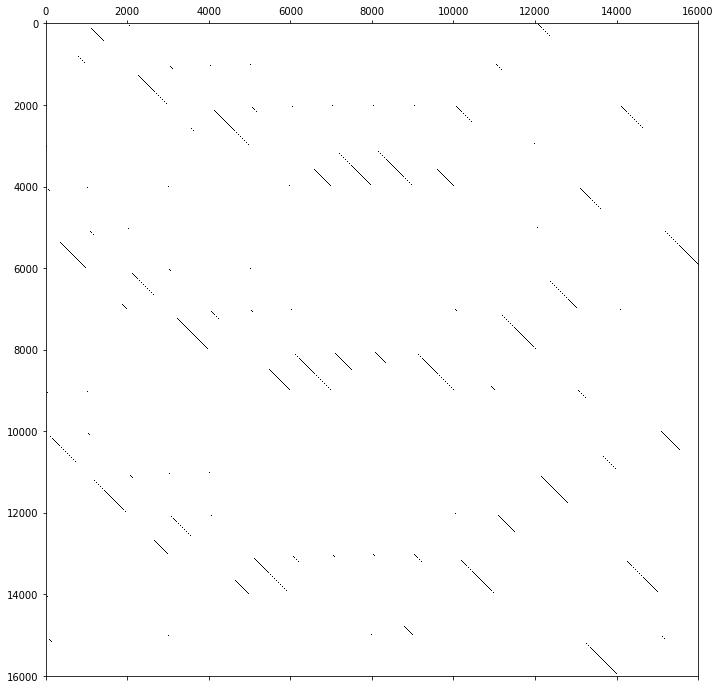

In [7]:
fig0, ax0 = plt.subplots(figsize=(12,12))
ax0.spy(Q.toarray())

The dimensions of the matrix correspond to $\text{vec}(\lambda(k, l))$.
In this case, the state space has two dimensions, one for the grid of capital and one for the grid of labor endowments.
The matrix `Q` is right-stochastic (its rows sum to one) and the ergodic distribution associated to the Markov Chain with transition matrix `Q` is the ergodic distribution over the state space.

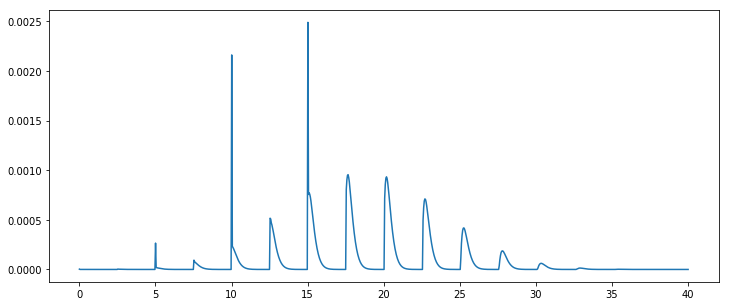

In [8]:
fig1, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(k, ergoDist[:, 0])